In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from rich import print
from python.analysis import Master, BeamParticleSelection, PFOSelection, Plots, shower_merging, vector, Tags

import awkward as ak
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from particle import Particle
from scipy.optimize import curve_fit


shower_merging.SetPlotStyle(extend_colors = True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
events = Master.Data("work/ROOTFiles/PDSPAnalyser/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03.root", nTuple_type = Master.Ntuple_Type.PDSP)

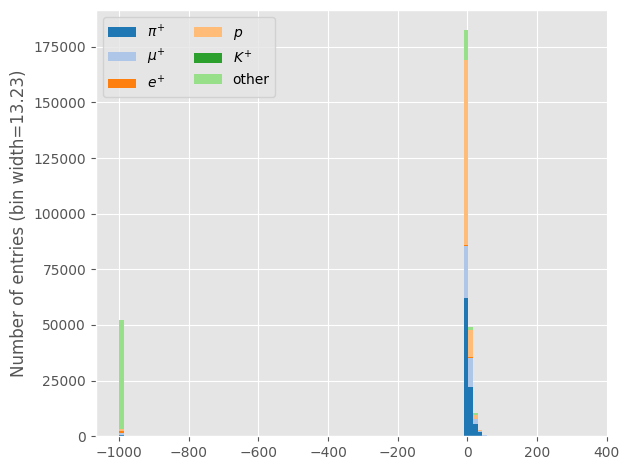

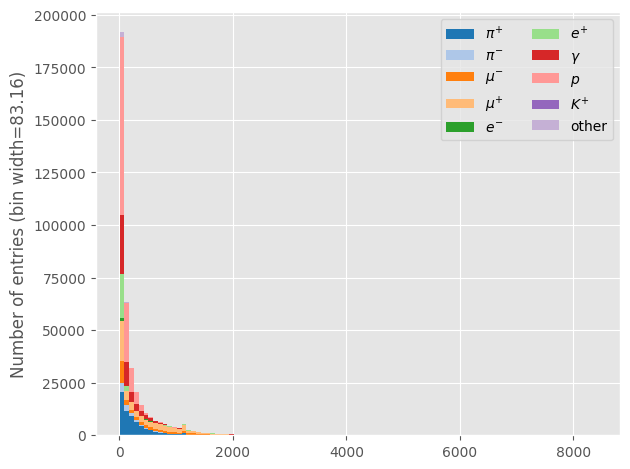

In [27]:
Plots.PlotTagged(events.recoParticles.beam_nHits, Tags.GenerateTrueBeamParticleTags(events))
Plots.PlotTagged(events.recoParticles.nHits, Tags.GenerateTrueParticleTags(events))

# Beam Particle Selection

number of entries before|after PiBeamSelection: 298194|133007


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to nTuple_type.
  warnings.warn(f"Couldn't apply filters to {var}.")


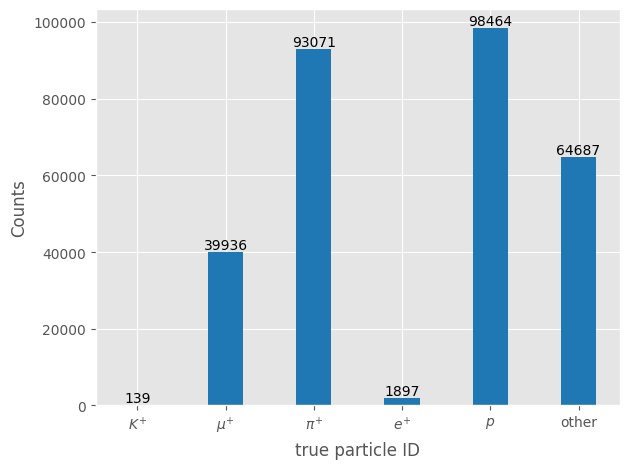

In [5]:
mask = BeamParticleSelection.PiBeamSelection(events)

counts = Tags.GenerateTrueBeamParticleTags(events)
for i in counts:
    counts[i] = ak.sum(counts[i].mask)

bar_data = []
for tag in counts:
    bar_data.extend([tag]*counts[tag])
Plots.PlotBar(bar_data, xlabel = "true particle ID")

events.Filter([mask], [mask])


number of entries before|after PandoraTagCut: 133007|131518


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to nTuple_type.
  warnings.warn(f"Couldn't apply filters to {var}.")


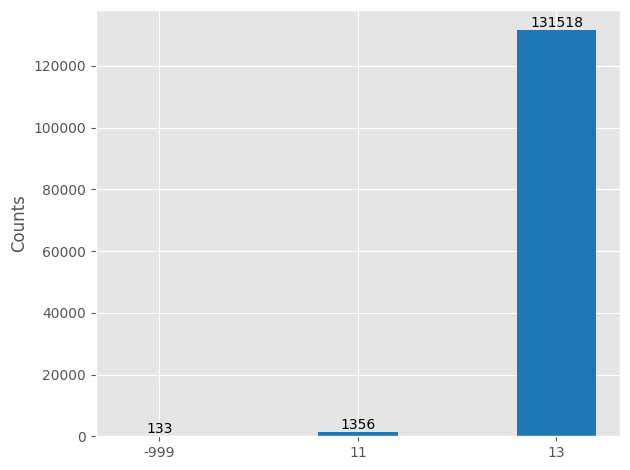

In [6]:
mask = BeamParticleSelection.PandoraTagCut(events)

Plots.PlotBar(events.recoParticles.beam_pandora_tag)

events.Filter([mask], [mask])

In [7]:
mask = BeamParticleSelection.CaloSizeCut(events)
events.Filter([mask], [mask])

number of entries before|after CaloSizeCut: 131518|129834


number of entries before|after MichelScoreCut: 129834|114698


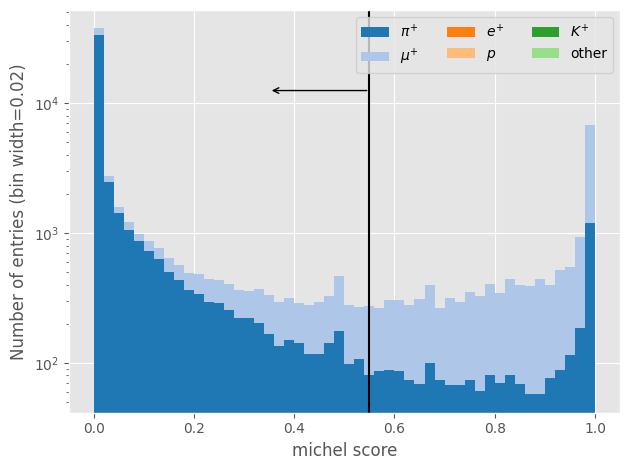

In [9]:
# michel score cut

score = ak.where(events.recoParticles.beam_nHits != 0, events.recoParticles.beam_michelScore / events.recoParticles.beam_nHits, -999)

Plots.PlotTagged(score, Tags.GenerateTrueBeamParticleTags(events), x_range = (0, 1), y_scale = "log", bins = 50, x_label = "michel score", ncols = 3)
Plots.DrawCutPosition(0.55, face = "left")
mask = BeamParticleSelection.MichelScoreCut(events)

events.Filter([mask], [mask])


{'x': -30.666309201588035, 'y': 422.21105517360195, 'z': 0.9714041702924682}

{'x': 5.12793218144155, 'y': 5.749670934743154, 'z': 1.8622685898591491}

dxy cut: (114698, 97132)

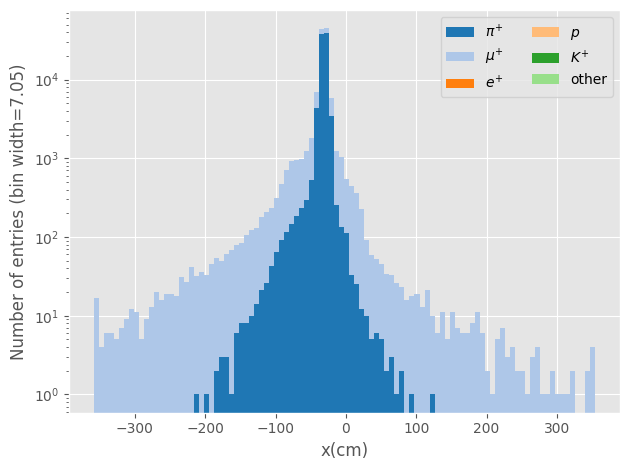

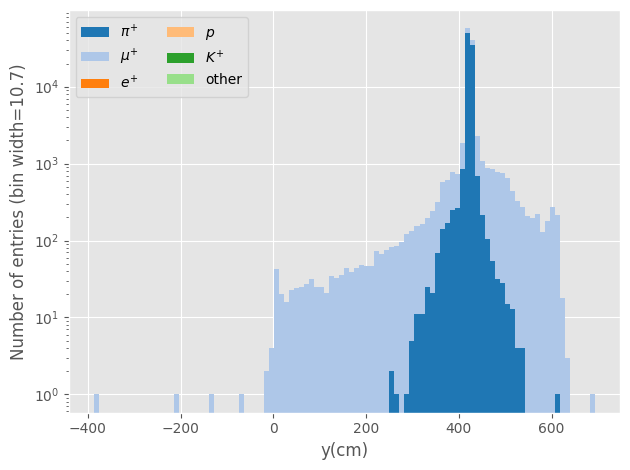

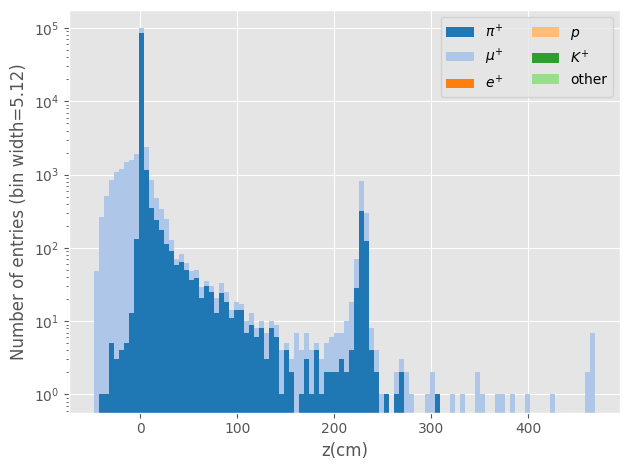

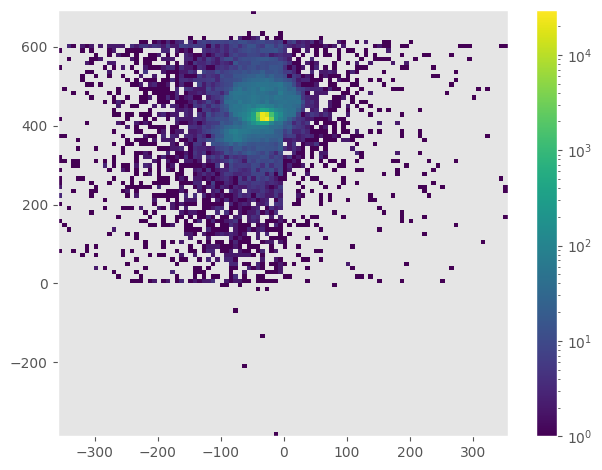

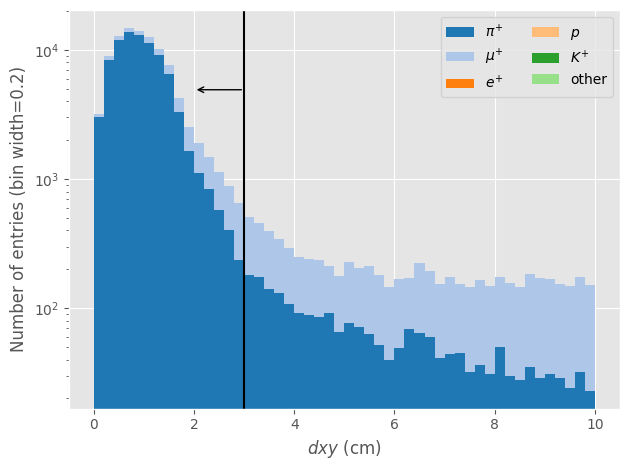

In [11]:
# Beam quality cuts

# Define the Gaussian function
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def fit_gaussian(data, bins, range = None):
    if range is None:
        range = [min(data), max(data)]
    y, bins_edges = np.histogram(np.array(data), bins = bins, range = range)
    bin_centers = (bins_edges[1:] + bins_edges[:-1]) / 2
    return curve_fit(gaussian, bin_centers, y, p0 = (0, ak.mean(data), ak.std(data)))

mu = {}
sigma = {}
for i in ["x", "y", "z"]:
    popt, _ = fit_gaussian(events.recoParticles.beam_startPos[i], bins = 100)
    mu[i] = popt[1]
    sigma[i] =popt[2]

print(mu)
print(sigma)

for i in ["x", "y", "z"]:
    Plots.PlotTagged(events.recoParticles.beam_startPos[i], Tags.GenerateTrueBeamParticleTags(events), x_label = i + "(cm)", y_scale = "log")

Plots.PlotHist2D(events.recoParticles.beam_startPos["x"], events.recoParticles.beam_startPos["y"])

dxy = (((events.recoParticles.beam_startPos.x - mu["x"]) / sigma["x"])**2 + ((events.recoParticles.beam_startPos.y - mu["y"]) / sigma["y"])**2)**0.5

Plots.PlotTagged(dxy, Tags.GenerateTrueBeamParticleTags(events), bins = 50, x_label = "$dxy$ (cm)", y_scale = "log", x_range = [0, 10])
Plots.DrawCutPosition(3, arrow_length = 1, face = "left")

mask = dxy < 3
print(f"dxy cut: {BeamParticleSelection.CountMask(mask)}")

events.Filter([mask], [mask])


dz cut: (97132, 95368)

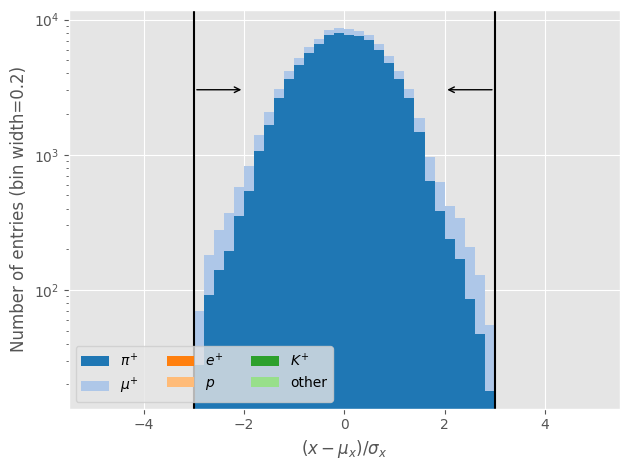

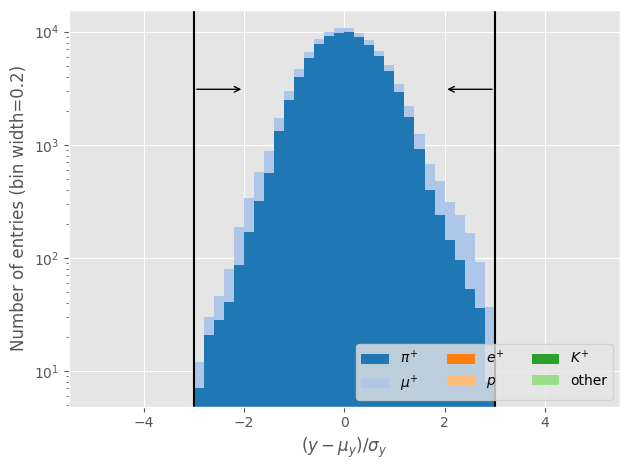

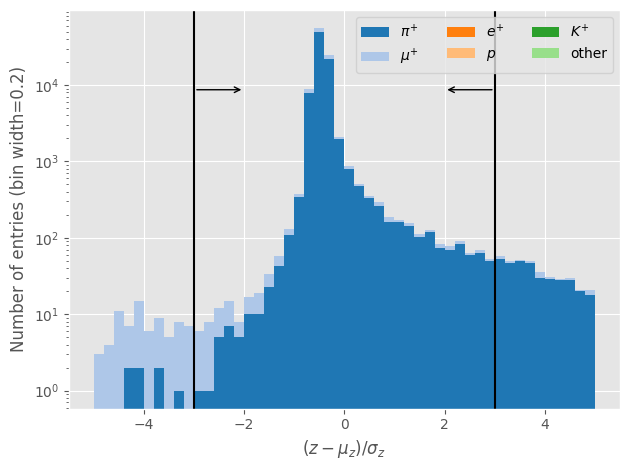

In [12]:
deltas = {}
for i in ["x", "y", "z"]:
    deltas[i] = (events.recoParticles.beam_startPos[i] - mu[i]) / sigma[i]
    Plots.PlotTagged(deltas[i], Tags.GenerateTrueBeamParticleTags(events), bins = 50, x_range = [-5, 5], y_scale = "log", x_label = f"$(" + i + "- \mu_{"+ i + "} )/ \sigma_{" + i + "}$", ncols = 3)
    # Plots.PlotHist((events.recoParticles.beam_startPos.z - popt[1]) / popt[2], bins = 200, range = [-5, 10])
    Plots.DrawCutPosition(-3, arrow_length = 1, face = "right")
    Plots.DrawCutPosition(3, arrow_length = 1, face = "left")

mask = deltas["z"] > -3
mask = mask & (deltas["z"] < 3)

events.Filter([mask], [mask])
print(f"dz cut: {BeamParticleSelection.CountMask(mask)}")

{'x': -0.2025788953995215, 'y': -0.1949476515683578, 'z': 0.9586230005901859}

{'x': 0.03545317121087179, 'y': 0.04174440963865302, 'z': 0.014930616685925472}

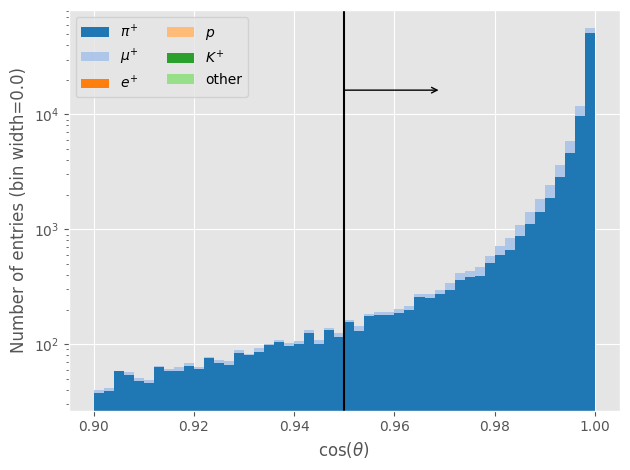

In [13]:
beam_dir = vector.normalize(vector.sub(events.recoParticles.beam_endPos, events.recoParticles.beam_startPos))

mu_dir = {}
sigma_dir = {}
for i in ["x", "y", "z"]:
    popt, _ = fit_gaussian(beam_dir[i], bins = 50)
    mu_dir[i] = popt[1]
    sigma_dir[i] = popt[2]

print(mu_dir)
print(sigma_dir)

beam_dir_mu = vector.normalize(vector.vector(mu_dir["x"], mu_dir["y"], mu_dir["z"]))

beam_costh = vector.dot(beam_dir, beam_dir_mu)

Plots.PlotTagged(beam_costh, Tags.GenerateTrueBeamParticleTags(events), x_label = "$\cos(\\theta)$", y_scale = "log", bins = 50, x_range = [0.9, 1])
Plots.DrawCutPosition(0.95, arrow_length = 0.02)

mask = beam_costh > 0.95
events.Filter([mask], [mask])


number of entries before|after APA3Cut: 90096|81525


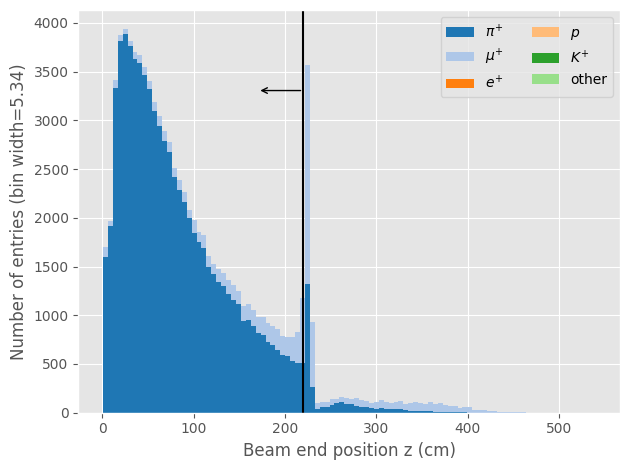

In [14]:
Plots.PlotTagged(events.recoParticles.beam_endPos.z, Tags.GenerateTrueBeamParticleTags(events), x_label = "Beam end position z (cm)")
Plots.DrawCutPosition(220, face = "left", arrow_length = 50)


mask = BeamParticleSelection.APA3Cut(events)
events.Filter([mask], [mask])

number of entries before|after MedianDEdXCut: 81525|79991


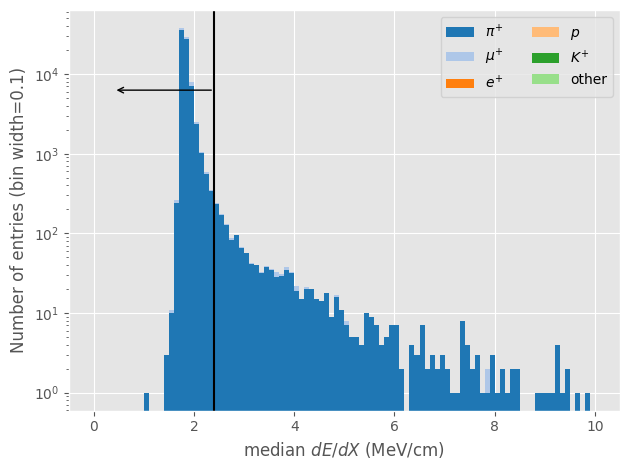

In [15]:
median = PFOSelection.Median(events.recoParticles.beam_dEdX)

Plots.PlotTagged(median, Tags.GenerateTrueBeamParticleTags(events), y_scale = "log", x_range = [0, 10], x_label = "median $dE/dX$ (MeV/cm)")
Plots.DrawCutPosition(2.4, face = "left", arrow_length = 2)

mask = BeamParticleSelection.MedianDEdXCut(events)
events.Filter([mask], [mask])

In [4]:
mask = BeamParticleSelection.CreateDefaultSelection(events, None, verbose = True, return_table = False)
events.Filter([mask], [mask])

mask = PFOSelection.GoodShowerSelection(events)
events.Filter([mask])


number of entries before|after PiBeamSelection: 298194|133007
number of entries before|after PandoraTagCut: 298194|245977
number of entries before|after CaloSizeCut: 298194|247361


/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


number of entries before|after MichelScoreCut: 298194|230193
number of entries before|after BeamQualityCut: 298194|182491
number of entries before|after APA3Cut: 298194|270725
number of entries before|after MedianDEdXCut: 298194|198023
                 number of events which pass the cut  single efficiency  \
no selection                                298194.0         100.000000   
PiBeamSelection                             133007.0          44.604184   
PandoraTagCut                               245977.0          82.488917   
CaloSizeCut                                 247361.0          82.953044   
MichelScoreCut                              230193.0          77.195718   
BeamQualityCut                              182491.0          61.198750   
APA3Cut                                     270725.0          90.788212   
MedianDEdXCut                               198023.0          66.407439   

                 number of events after successive cuts  \
no selection                 

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to nTuple_type.
  warnings.warn(f"Couldn't apply filters to {var}.")


number of entries before|after ValidRecoPositionCut: 162531|155514
number of entries before|after ValidRecoMomentumCut: 162531|142970
number of entries before|after ValidRecoEnergyCut: 162531|142970


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_pandora_tag.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_caloWire.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_nHits.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_michelScore.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_startPos.
  warnings.warn(f"Couldn't apply filters

# $\pi^{+}$ Particle Selection

number of entries before|after BeamDaughterCut: 67476|505


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_number.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_pandora_tag.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_caloWire.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_startPos.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/

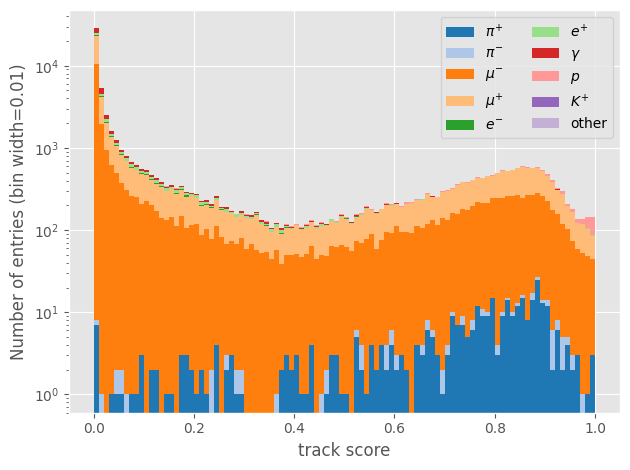

In [4]:
mask = PFOSelection.BeamDaughterCut(events)
Plots.PlotTagged(events.recoParticles.trackScore, Tags.GenerateTrueParticleTags(events), y_scale = "log", x_label = "track score")
events.Filter([mask])


number of entries before|after TrackScoreCut: 505|324


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_number.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_pandora_tag.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_startPos.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_endPos.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Do

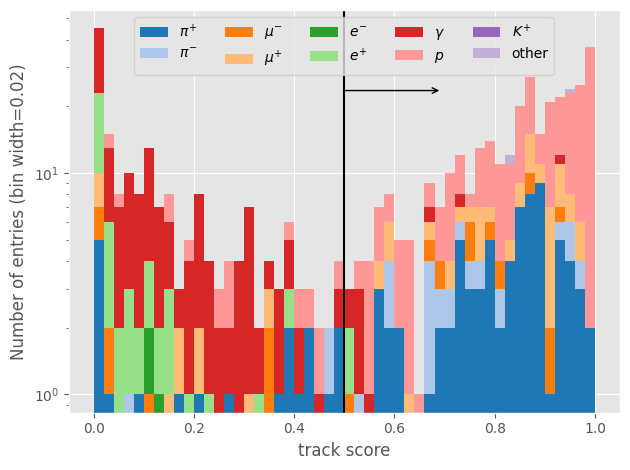

In [53]:
Plots.PlotTagged(events.recoParticles.trackScore, Tags.GenerateTrueParticleTags(events), y_scale = "log", bins = 50, ncols = 5, x_label = "track score")
Plots.DrawCutPosition(0.5, face = "right")
mask = PFOSelection.TrackScoreCut(events)
events.Filter([mask])

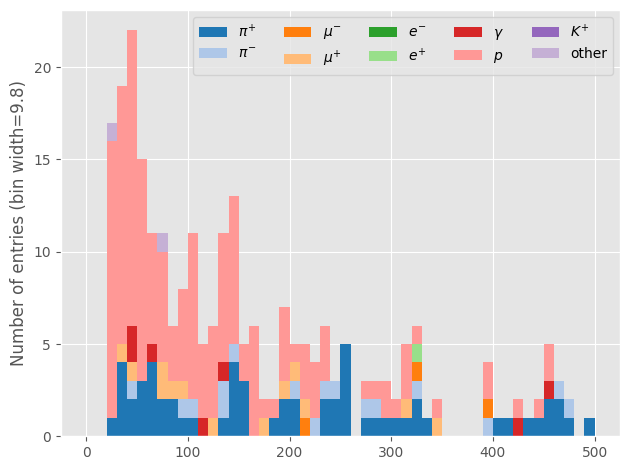

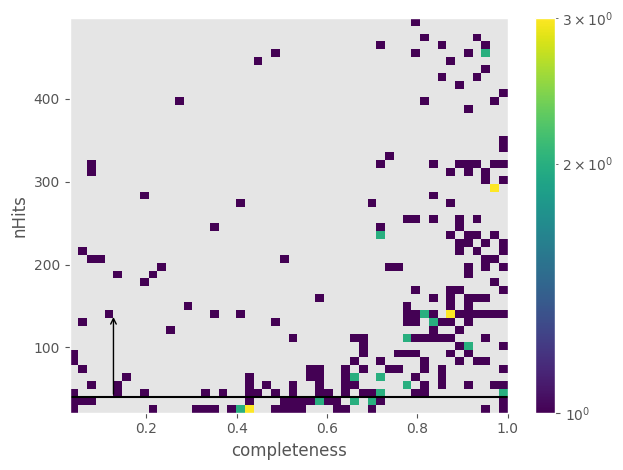

In [64]:
Plots.PlotTagged(events.recoParticles.nHits, Tags.GenerateTrueParticleTags(events), bins = 50, ncols = 5, range = [0, 500])
Plots.PlotHist2D(ak.ravel(events.trueParticlesBT.completeness), ak.ravel(events.recoParticles.nHits), xlabel = "completeness", ylabel = "nHits", y_range = [0, 500], bins = 50)
Plots.DrawCutPosition(20, flip = True, arrow_length = 100, arrow_loc = 0.1)
# mask = PFOSelection.NHitsCut(events, 20)
# events.Filter([mask])

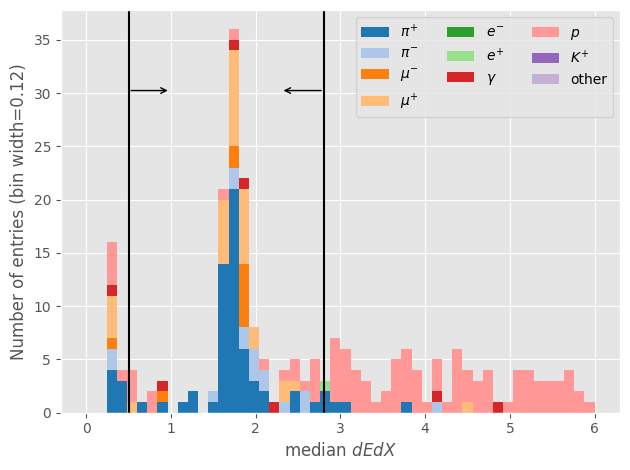

In [66]:
median_dEdX = PFOSelection.Median(events.recoParticles.track_dEdX)
Plots.PlotTagged(median_dEdX, Tags.GenerateTrueParticleTags(events), ncols = 3, range = [0, 6], x_label = "median $dEdX$", bins = 50)

Plots.DrawCutPosition(0.5, arrow_length = 0.5, face = "right")
Plots.DrawCutPosition(2.8, arrow_length = 0.5, face = "left")

# mask = PFOSelection.PiPlusSelection(events)
# events.Filter([mask], [mask])


(['$\\gamma$',
  '$\\mu^{+}$',
  '$\\mu^{-}$',
  '$\\pi^{+}$',
  '$\\pi^{-}$',
  '$e^{+}$',
  '$p$'],
 [4, 28, 9, 56, 13, 1, 16])

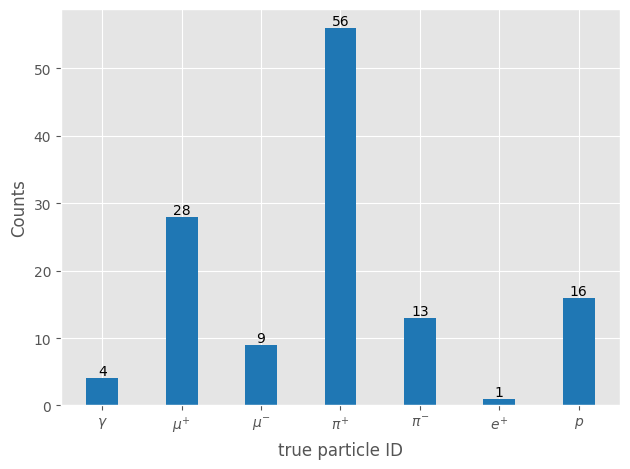

In [10]:
tags = Tags.GenerateTrueParticleTags(events)
bar_data = []
for tag in tags:
    bar_data.extend([tag]*ak.sum(tags[tag]))

Plots.PlotBar(bar_data, xlabel = "true particle ID")
# print(bar_data)

# print(np.unique(bar_data, return_counts = True))


# photon candidate selection

number of entries before|after EMScoreCut: 142970|46404


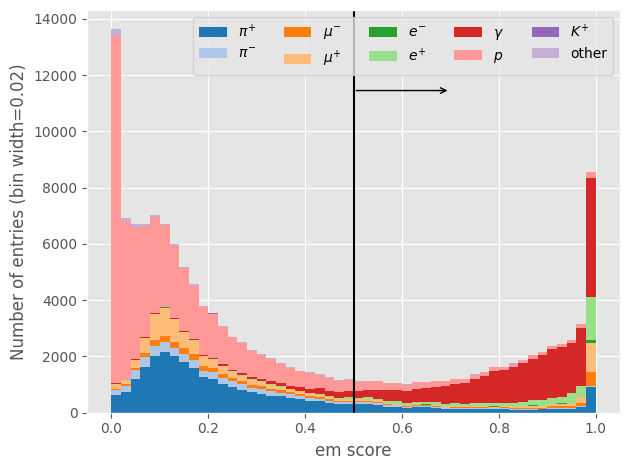

In [7]:
Plots.PlotTagged(events.recoParticles.emScore, Tags.GenerateTrueParticleTags(events), bins = 50, range = [0, 1], ncols = 5, x_label = "em score")
Plots.DrawCutPosition(0.5)
mask = PFOSelection.EMScoreCut(events, 0.5)
events.Filter([mask])

number of entries before|after NHitsCut: 46404|21931


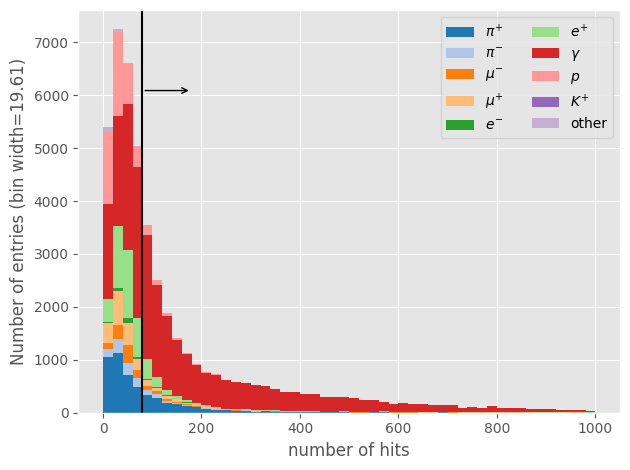

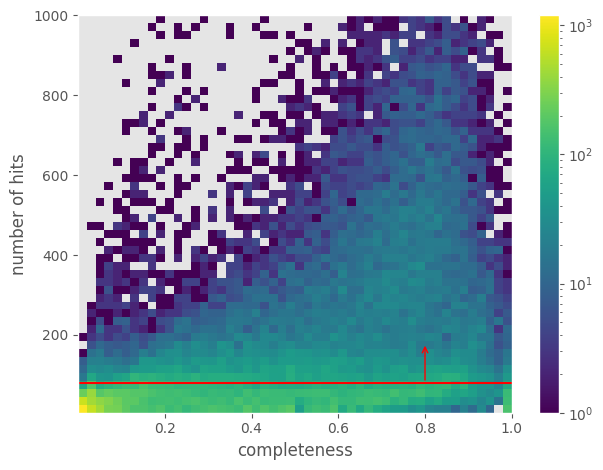

In [8]:
Plots.PlotTagged(events.recoParticles.nHits, Tags.GenerateTrueParticleTags(events), bins = 50, x_label = "number of hits", range = [0, 1000])
Plots.DrawCutPosition(80, arrow_length = 100)

Plots.PlotHist2D(ak.ravel(events.trueParticlesBT.completeness), ak.ravel(events.recoParticles.nHits), bins = 50, x_range = [0, 1],y_range = [0, 1000], xlabel = "completeness", ylabel = "number of hits")
Plots.DrawCutPosition(80, flip = True, arrow_length = 100, color = "red")

mask = PFOSelection.NHitsCut(events, 80)

events.Filter([mask])

number of entries before|after BeamParticleDistanceCut: 21931|20084


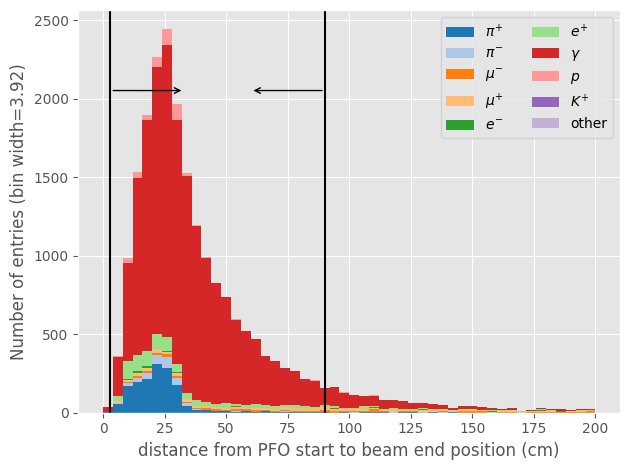

In [9]:
dist = PFOSelection.find_beam_separations(events)
Plots.PlotTagged(dist, Tags.GenerateTrueParticleTags(events), bins = 50, range = [0, 200], x_label = "distance from PFO start to beam end position (cm)")

Plots.DrawCutPosition(3, arrow_length = 30)
Plots.DrawCutPosition(90, face = "left", arrow_length = 30)

mask = PFOSelection.BeamParticleDistanceCut(events, [3, 90])
events.Filter([mask])

number of entries before|after BeamParticleIPCut: 20084|13334


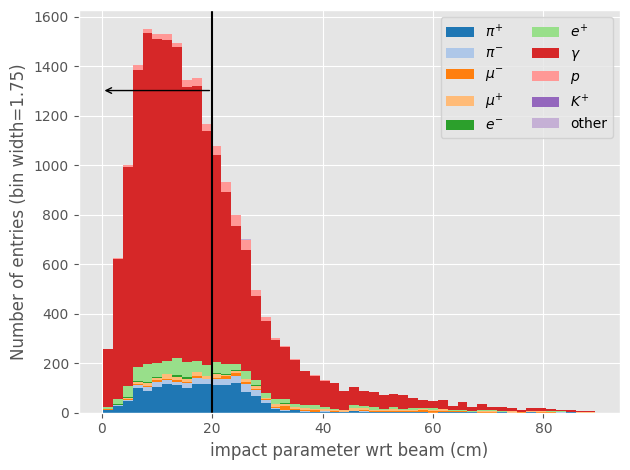

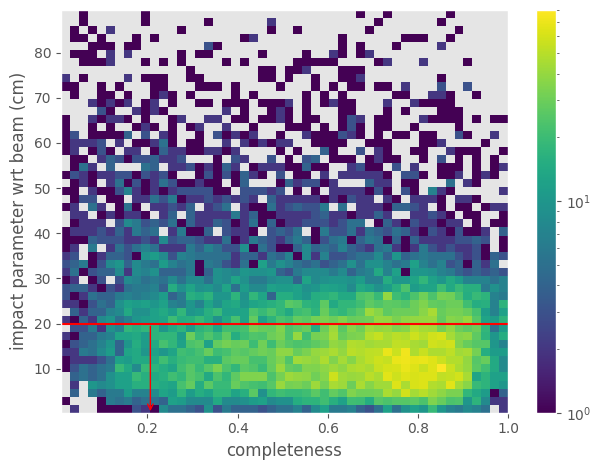

In [10]:
ip = PFOSelection.find_beam_impact_parameters(events)
Plots.PlotTagged(ip, Tags.GenerateTrueParticleTags(events), bins = 50, x_label = "impact parameter wrt beam (cm)")
Plots.DrawCutPosition(20, arrow_length = 20, face = "left")

Plots.PlotHist2D(ak.ravel(events.trueParticlesBT.completeness), ak.ravel(ip), bins = 50, x_range = [0, 1], xlabel = "completeness", ylabel = "impact parameter wrt beam (cm)")
Plots.DrawCutPosition(20, arrow_loc = 0.2, arrow_length = 20, face = "left", flip = True, color ="red")

mask = PFOSelection.BeamParticleIPCut(events, 20)
events.Filter([mask])


(['$\\gamma$',
  '$\\mu^{+}$',
  '$\\mu^{-}$',
  '$\\pi^{+}$',
  '$\\pi^{-}$',
  '$e^{+}$',
  '$e^{-}$',
  '$p$',
  'other'],
 [11325, 110, 53, 939, 150, 526, 34, 196, 1])

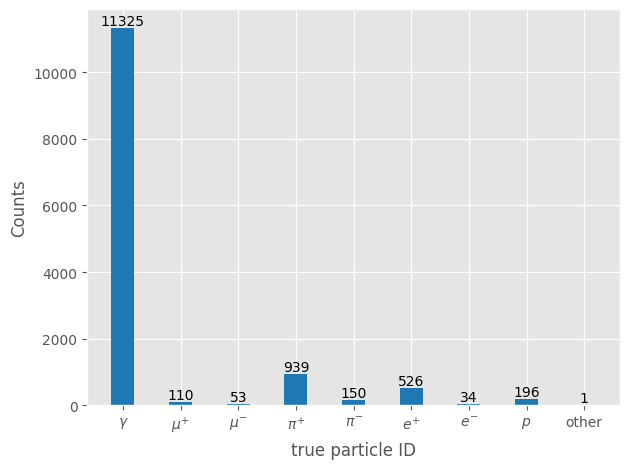

In [11]:
tags = Tags.GenerateTrueParticleTags(events)
bar_data = []
for tag in tags:
    bar_data.extend([tag]*ak.sum(tags[tag]))

Plots.PlotBar(bar_data, xlabel = "true particle ID")

# $\pi^{0}$ selection

number of entries before|after EMScoreCut: 142970|46404
number of entries before|after NHitsCut: 142970|81288
number of entries before|after BeamParticleDistanceCut: 142970|132645
number of entries before|after BeamParticleIPCut: 142970|101453
number of entries before|after VetoBeamParticle: 142970|142970


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to nTuple_type.
  warnings.warn(f"Couldn't apply filters to {var}.")


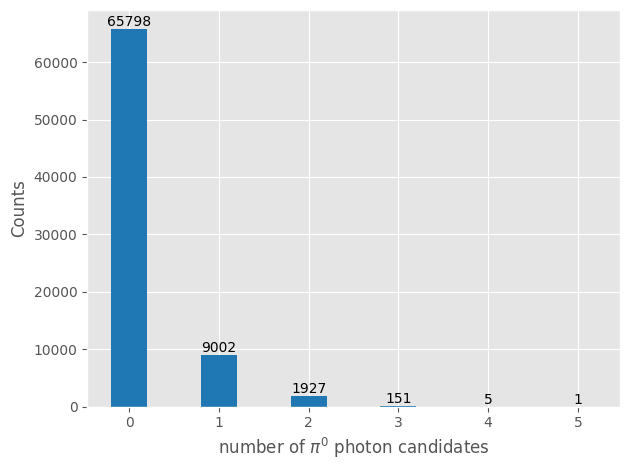

In [5]:
photonCandidates = PFOSelection.InitialPi0PhotonSelection(events) # repeat the photon candidate selection, but only require the mask
n_photons = ak.sum(photonCandidates, -1)
mask = n_photons == 2

Plots.PlotBar(n_photons, xlabel = "number of $\pi^{0}$ photon candidates")
events.Filter([mask], [mask])

In [14]:
print(np.unique(n_photons, return_counts = True))
print(np.unique(n_photons[n_photons == 2], return_counts = True))

print(ak.num(events.recoParticles.number, 1))
print(ak.num(events.trueParticlesBT.number, 1))

# Master.ShowerPairs.GetPairsFromMask(photonCandidates)

shower_pairs = Master.ShowerPairs(events, shower_pair_mask = photonCandidates[mask])
print(ak.count(ak.flatten(shower_pairs.reco_angle)))

(array([0, 1, 2, 3, 4, 5]), array([65798,  9002,  1927,   151,     5,     1]))

(array([2]), array([1927]))

[7, 3, 2, 2, 3, 3, 2, 3, 4, 3, 4, 3, 8, 4, ... 4, 3, 3, 3, 3, 3, 3, 2, 2, 3, 4, 3, 2]

[7, 3, 2, 2, 3, 3, 2, 3, 4, 3, 4, 3, 8, 4, ... 4, 3, 3, 3, 3, 3, 3, 2, 2, 3, 4, 3, 2]

1927

some tags do not have colours, will override them for the default ones


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to nTuple_type.
  warnings.warn(f"Couldn't apply filters to {var}.")


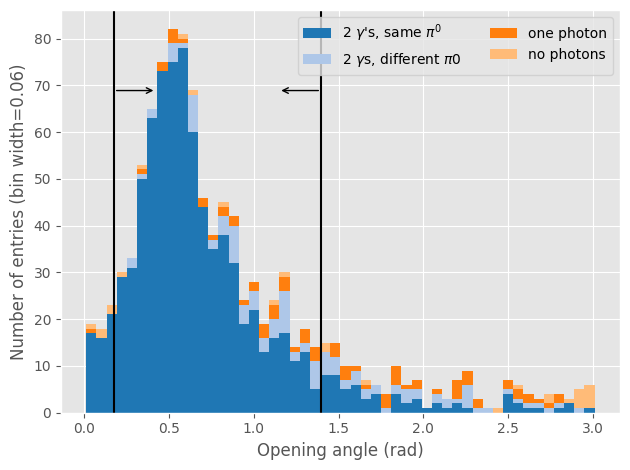

In [17]:
photonCandidates_2 = photonCandidates[n_photons == 2]
shower_pairs = Master.ShowerPairs(events, shower_pair_mask = photonCandidates_2)

angle = ak.flatten(shower_pairs.reco_angle)

Plots.PlotTagged(angle, Tags.GeneratePi0Tags(events), bins = 50, x_label = "Opening angle (rad)")
Plots.DrawCutPosition(10 * np.pi / 180, face = "right", arrow_length = 0.25)
Plots.DrawCutPosition(80 * np.pi / 180, face = "left", arrow_length = 0.25)

mask = (angle > (10 * np.pi / 180)) & (angle < (80 * np.pi / 180))

events.Filter([mask], [mask])

some tags do not have colours, will override them for the default ones


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to nTuple_type.
  warnings.warn(f"Couldn't apply filters to {var}.")


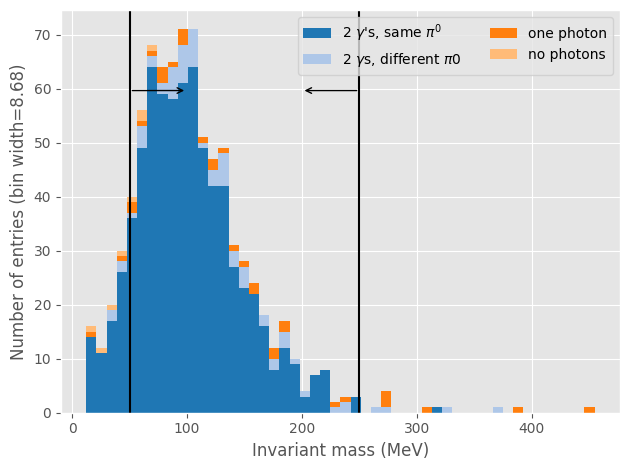

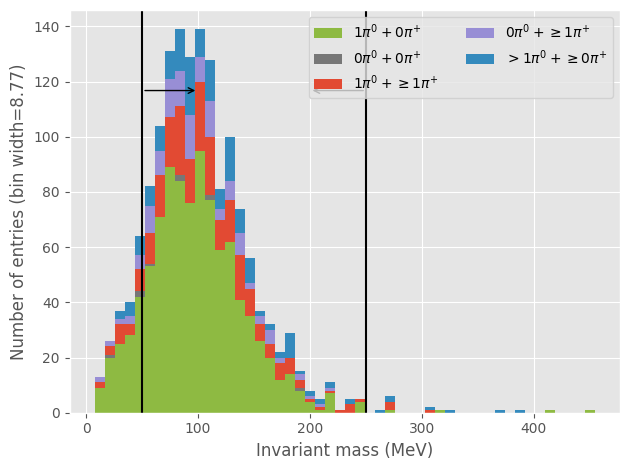

In [20]:
photonCandidates_2_angle = photonCandidates_2[(angle > (10 * np.pi / 180)) & (angle < (80 * np.pi / 180))]
shower_pairs = Master.ShowerPairs(events, shower_pair_mask = photonCandidates_2_angle)

mass = ak.flatten(shower_pairs.reco_mass)

Plots.PlotTagged(mass, Tags.GeneratePi0Tags(events), bins = 50, x_label = "Invariant mass (MeV)")
Plots.DrawCutPosition(50, face = "right", arrow_length = 50)
Plots.DrawCutPosition(250, face = "left", arrow_length = 50)

Plots.PlotTagged(mass, Tags.GenerateTrueFinalStateTags(events), bins = 50, x_label = "Invariant mass (MeV)")
Plots.DrawCutPosition(50, face = "right", arrow_length = 50)
Plots.DrawCutPosition(250, face = "left", arrow_length = 50)

mask = (mass > 50) & (mass < 250)
events.Filter([mask], [mask])

In [23]:
event_topology_tags = Tags.GenerateTrueFinalStateTags(events)

for t in event_topology_tags:
    print(event_topology_tags[t].name_simple, ak.sum(event_topology_tags[t].mask), ak.count(event_topology_tags[t].mask))

exclusive signal 849 1347

background 6 1347

sideband 218 1347

sideband 120 1347

sideband 154 1347